### Example 5: Laplace equation

In this tutorial we will look constructing the steady-state heat example using the Laplace equation. In contrast to the previous tutorials this example is entirely driven by the prescribed Dirichlet and Neumann boundary conditions, instead of an initial condition. We will also demonstrate how to use Devito to solve a steady-state problem without time derivatives and how to switch buffers explicitly without having to re-compile the kernel.

First, we again define our governing equation:
$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0$$

We are again discretizing second-order derivatives using a central difference scheme to construct a diffusion problem (see tutorial 3). This time we have no time-dependent term in our equation though, since there is no term $p_{i,j}^{n+1}$. This means that we are simply updating our field variable $p$ over and over again, until we have reached an equilibrium state. In a discretised form, after rearranging to update the central point $p_{i,j}^n$ we have
$$p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n+p_{i-1,j}^n)+\Delta x^2(p_{i,j+1}^n + p_{i,j-1}^n)}{2(\Delta x^2 + \Delta y^2)}$$

And, as always, we first re-create the original implementation to see what we are aiming for. Here we initialise the field $p$ to $0$ and apply the following bounday conditions:

$p=0$ at $x=0$
 
$p=y$ at $x=2$
 
$\frac{\partial p}{\partial y}=0$ at $y=0, \ 1$

**Developer note:**
The original tutorial stores the field data in the layout `(ny, nx)`. Until now we have used `(x, y)` notation for creating our Devito examples, but for this one we will adopt the `(y, x)` layout for compatibility reasons.

In [1]:
from examples.cfd import plot_field
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 31
ny = 31
c = 1
dx = 2. / (nx - 1)
dy = 1. / (ny - 1)

In [2]:
def laplace2d(p, bc_y, dx, dy, l1norm_target):
    l1norm = 1
    pn = np.empty_like(p)

    while l1norm > l1norm_target:
        pn = p.copy()
        p[1:-1, 1:-1] = ((dy**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) +
                         dx**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1])) /
                        (2 * (dx**2 + dy**2)))
            
        p[:, 0] = 0  # p = 0 @ x = 0
        p[:, -1] = bc_right  # p = y @ x = 2
        p[0, :] = p[1, :]  # dp/dy = 0 @ y = 0
        p[-1, :] = p[-2, :]  # dp/dy = 0 @ y = 1
        l1norm = (np.sum(np.abs(p[:]) - np.abs(pn[:])) /
                  np.sum(np.abs(pn[:])))
     
    return p

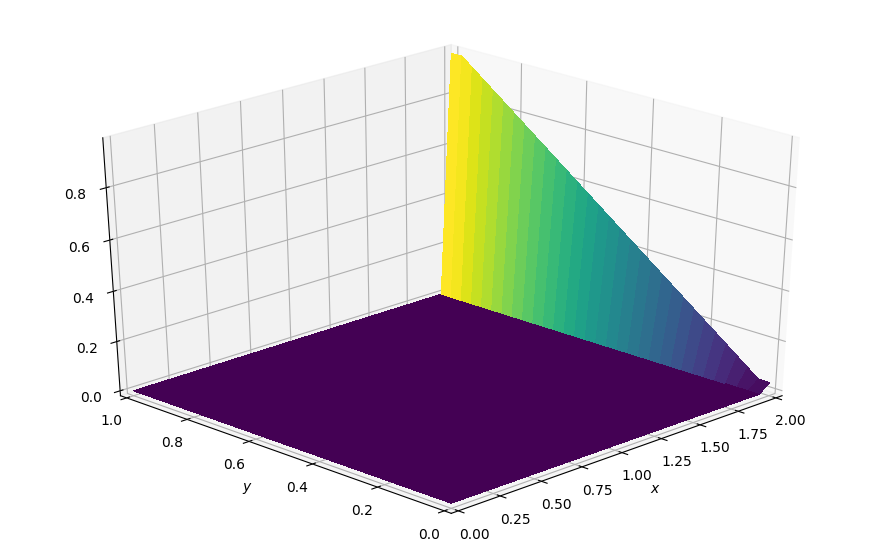

In [3]:
#NBVAL_IGNORE_OUTPUT

# Out initial condition is 0 everywhere,except at the boundary
p = np.zeros((ny, nx))

# Boundary conditions
bc_right = np.linspace(0, 1, ny)
p[:, 0] = 0  # p = 0 @ x = 0
p[:, -1] = bc_right  # p = y @ x = 2
p[0, :] = p[1, :]  # dp/dy = 0 @ y = 0
p[-1, :] = p[-2, :]  # dp/dy = 0 @ y = 1

plot_field(p, ymax=1.0, view=(30, 225))

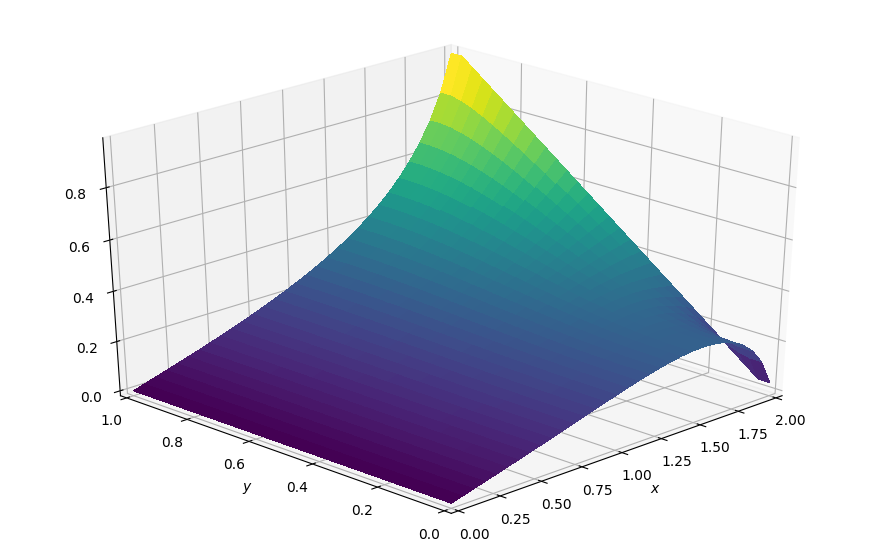

In [4]:
#NBVAL_IGNORE_OUTPUT

p = laplace2d(p, bc_right, dx, dy, 1e-4)
plot_field(p, ymax=1.0, view=(30, 225))

Ok, nice. Now, to re-create this example in Devito we need to look a little bit further under the hood. There are two things that make this different to the examples we covered so far:
* We have no time dependence in the `p` field, but we still need to advance the state of p in between buffers. So, instead of using `TimeFunction` objects that provide multiple data buffers for timestepping schemes, we will use `Function` objects that have no time dimension and only allocate a single buffer according to the space dimensions. However, since we are still implementing a pseudo-timestepping loop, we will need to objects, say `p` and `pn`, to act as alternating buffers.
* If we're using two different symbols to denote our buffers, any operator we create will only perform a single timestep. This is desired though, since we need to check a convergence criteria outside of the main stencil update to determine when we stop iterating. As a result we will need to call the operator repeatedly after instantiating it outside the convergence loop.

So, how do we make sure our operator doesn't accidentally overwrite values in the same buffer? Well, we can again let SymPy reorganise our Laplace equation based on `pn` to generate the stencil, but when we create the update expression, we set the LHS to our second buffer variable `p`.

In [5]:
from devito import Grid, Function, Eq, INTERIOR
from sympy import solve

# Create two explicit buffers for pseudo-timestepping
grid = Grid(shape=(nx, ny), extent=(1., 2.))
p = Function(name='p', grid=grid, space_order=2)
pn = Function(name='pn', grid=grid, space_order=2)

# Create Laplace equation base on `pn`
eqn = Eq(pn.laplace, region=INTERIOR)
# Let SymPy solve for the central stencil point
stencil = solve(eqn, pn)[0]
# Now we let our stencil populate our second buffer `p`
eq_stencil = Eq(p, stencil)

# In the resulting stencil `pn` is exclusively used on the RHS
# and `p` on the LHS is the grid the kernel will update
print("Update stencil:\n%s\n" % eq_stencil)

Update stencil:
Eq(p(x, y), 0.5*(h_x**2*pn(x, y - h_y) + h_x**2*pn(x, y + h_y) + h_y**2*pn(x - h_x, y) + h_y**2*pn(x + h_x, y))/(h_x**2 + h_y**2))



Now we can add our boundary conditions. We have already seen how to prescribe constant Dirichlet BCs by simply setting values using the low-level notation. This time we will go a little further by setting a prescribed profile, which we create first as a custom 1D symbol and supply with the BC values. For this we need to create a `Function` object that has a different shape than our general `grid`, so instead of the grid we provide an explicit pair of dimension symbols and the according shape for the data.

In [6]:
x, y = grid.dimensions
bc_right = Function(name='bc_right', shape=(nx, ), dimensions=(x, ))
bc_right.data[:] = np.linspace(0, 1, nx)

Now we can create a set of expressions for the BCs again, where we wet prescribed values on the right and left of our grid. For the Neuman BCs along the top and bottom boundaries we simply copy the second rwo from the outside into the outermost row, just as the original tutorial did. Using these expressions and our stencil update we can now create an operator.

In [7]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

# Create boundary condition expressions
bc = [Eq(p.indexed[x, 0], 0.)]  # p = 0 @ x = 0
bc += [Eq(p.indexed[x, ny-1], bc_right.indexed[x])]  # p = y @ x = 2
bc += [Eq(p.indexed[0, y], p.indexed[1, y])]  # dp/dy = 0 @ y = 0
bc += [Eq(p.indexed[nx-1, y], p.indexed[nx-2, y])]  # dp/dy = 0 @ y = 1

# Now we can build the operator that we need
op = Operator(expressions=[eq_stencil] + bc)

We can now use this single-step operator repeatedly in a Python loop, where we can arbitrarily execute other code in between invocations. This allows us to update our L1 norm and check for convergence. Using our pre0compiled operator now comes down to a single function call that supplies the relevant data symbols. One thing to note is that we now do exactly the same thing as the original NumPy loop, in that we deep-copy the data between each iteration of the loop, which we will look at after this.

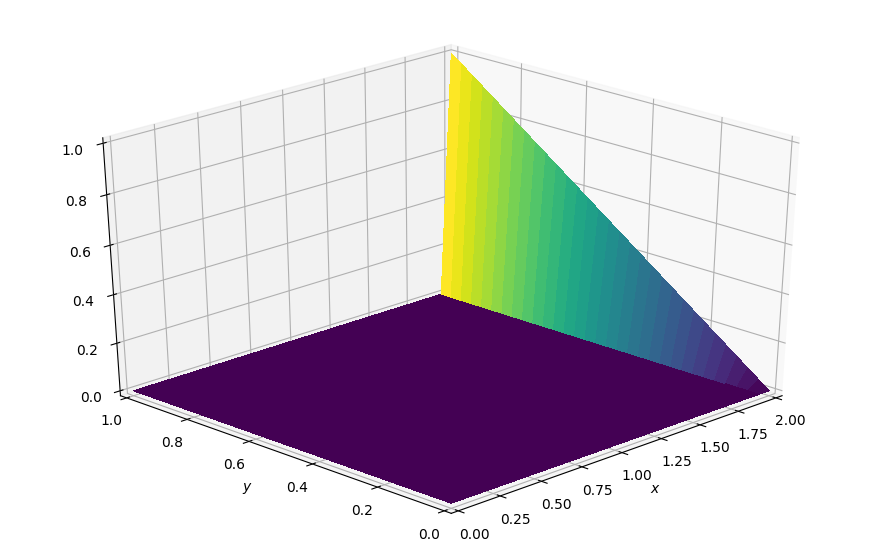

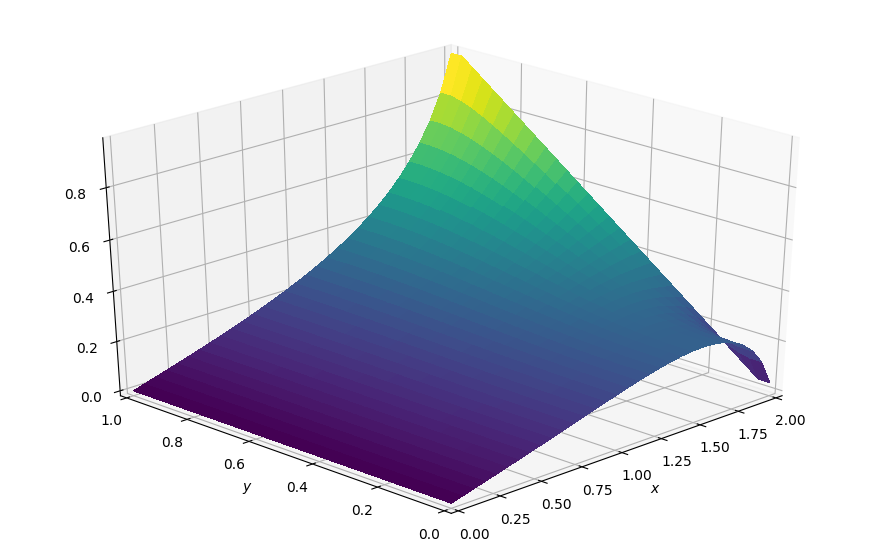

In [8]:
#NBVAL_IGNORE_OUTPUT

# Silence the runtime performance logging
from devito import configuration
configuration['log_level'] = 'ERROR'

# Initialise the two buffer fields
p.data[:] = 0.
p.data[:, -1] = np.linspace(0, 1, ny)
pn.data[:] = 0.
pn.data[:, -1] = np.linspace(0, 1, ny)

# Visualize the initial condition
plot_field(p.data, ymax=1.0, view=(30, 225))

# Run the convergence loop with deep data copies
l1norm_target = 1.e-4
l1norm = 1
while l1norm > l1norm_target:
    # This call implies a deep data copy
    pn.data[:] = p.data[:]
    op(p=p, pn=pn)
    
    l1norm = (np.sum(np.abs(p.data[:]) - np.abs(pn.data[:])) /
              np.sum(np.abs(pn.data[:])))

# Visualize the converged steady-state
plot_field(p.data, ymax=1.0, view=(30, 225))

One crucial detail about the code above is that the deep data copy between iterations will really hurt performance if we were to run this on a large grid. However, we have already seen how we can match data symbols to symbolic names when calling the pre-compiled operator, which we can now use to actually switch the roles of `pn` and `p` between iterations, eg. `op(p=pn, pn=p)`. Thus, we can implement a simple buffer-switching scheme by simply testing for odd and even time-steps, without ever having to shuffle data around.

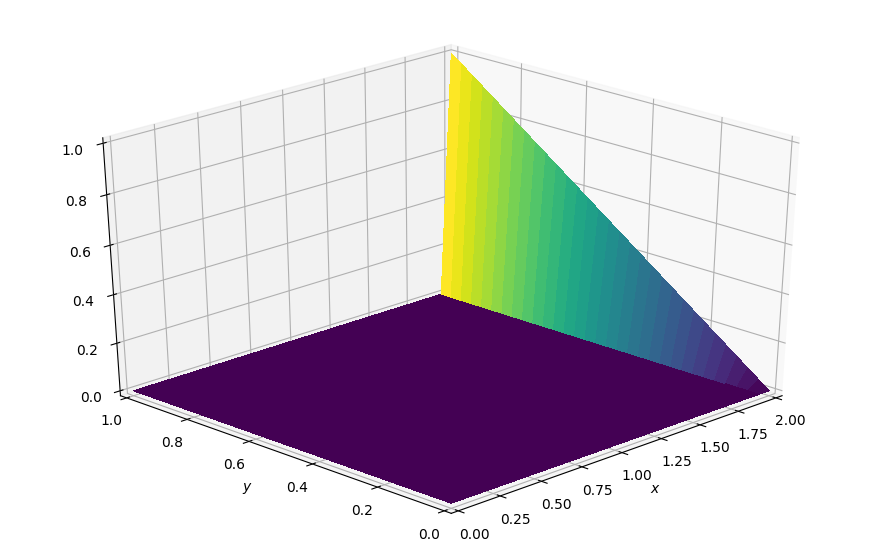

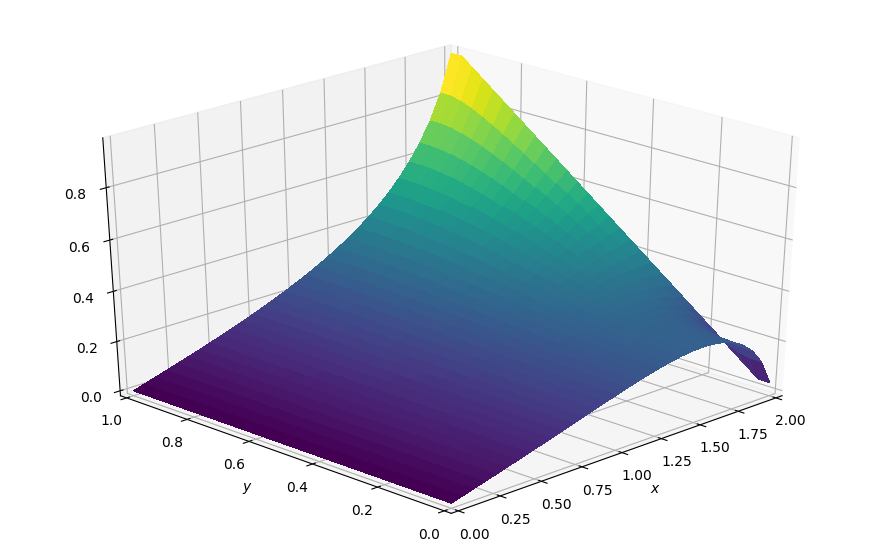

In [9]:
#NBVAL_IGNORE_OUTPUT

# Initialise the two buffer fields
p.data[:] = 0.
p.data[:, -1] = np.linspace(0, 1, ny)
pn.data[:] = 0.
pn.data[:, -1] = np.linspace(0, 1, ny)

# Visualize the initial condition
plot_field(p.data, ymax=1.0, view=(30, 225))

# Run the convergence loop by explicitly flipping buffers
l1norm_target = 1.e-4
l1norm = 1
counter = 0
while l1norm > l1norm_target:
    # Determine buffer order
    if counter % 2 == 0:
        _p = p
        _pn = pn
    else:
        _p = pn
        _pn = p

    # Apply operator
    op(p=_p, pn=_pn)
    
    # Compute L1 norm
    l1norm = (np.sum(np.abs(_p.data[:]) - np.abs(_pn.data[:])) /
              np.sum(np.abs(_pn.data[:])))
    counter += 1
     
plot_field(p.data, ymax=1.0, view=(30, 225))